## Studying the attenuation by geometry elements 500nm

In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
import rat

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
def doRead(ratreader = None, radius_pass = 6200., max_photons = 100000, single=False):
    end_position     = np.zeros([max_photons, 3])
    theta_dir        = np.zeros(max_photons)
    step_r           = np.zeros(max_photons)
    end_volume       = ['volume']*max_photons
    end_process      = ['process']*max_photons
    counter = 0
    for ds, run in ratreader:
        mymc = ds.GetMC()
        
        if counter >= max_photons:
            break
        
        # Loop over all the photons
        for itrack in range(1, mymc.GetMCTrackCount()+1):
            mytrack = mymc.GetMCTrack(itrack)
            
            # End here to study the info in a track
            if single:
                #print mymc.GetMCTrackCount()+1
                return mytrack
            
            max_steps = mymc.GetMCTrack(itrack).GetMCTrackStepCount()              
            
            # The step 0 is always the starting point. Start at one.
            first_step = mymc.GetMCTrack(itrack).GetMCTrackStep(1).GetPosition()
            step_r[counter]    = np.linalg.norm(first_step)

            # Get the initial direction of the photon
            # I'm intersted in theta_dir = [8, 82] degrees
            theta_dir[counter] = np.arccos(first_step[2]/step_r[counter])
            
            # Get the last step
            last_step = mymc.GetMCTrack(itrack).GetMCTrackStep(max_steps-1)

            # Also get the end volume
            end_volume[counter] = last_step.GetEndVolume()
            end_position[counter,:] = last_step.GetPosition()
            end_process[counter] = last_step.GetProcess()
            counter += 1
            
            if counter >= max_photons:
                break
                
    ratreader.close()
    
    data = {'step_r':step_r[:counter],
            'theta_dir':theta_dir[:counter],
            'end_position':end_position[:counter,:],
            'end_volume':np.array(end_volume[:counter]),
            'end_process':np.array(end_process[:counter])}
        
    return data

In [3]:
def openRat(infile_dir, infile_name, *ratreader):
    try:
        ratreader.close()
        print 'Closing file before reopenning'
    except:
        print 'No ratreader file. Opening it for the first time'
    full_name = os.path.join(infile_dir, infile_name)
    if os.path.exists(full_name):
        ratreader = rat.dsreader(full_name)
    else:
        print 'File does not exist'
        print full_name
    return ratreader

In [4]:
ratreader = None

In [5]:
# Opening the file
infile_dir = '/home/jp/projects/snoplus/ratout/nativegeo_validation/tracking_nopmt/snoplus_nopipes'
infile_name = 'pbomb500.root'
ratreader = openRat(infile_dir, infile_name, ratreader)

No ratreader file. Opening it for the first time


In [6]:
snoplus = doRead(ratreader=ratreader, max_photons = 10000000)

In [7]:
np.unique(snoplus['end_volume'])

array(['av', 'cavity', 'hold_down_ropes', 'hold_up_ropes_0',
       'hold_up_ropes_1', 'hold_up_ropes_2', 'hold_up_ropes_3',
       'hold_up_ropes_4', 'hold_up_ropes_5', 'hold_up_ropes_6',
       'hold_up_ropes_7', 'hold_up_ropes_8', 'hold_up_ropes_9', 'inner_av',
       'ncd_anchors_0', 'ncd_anchors_10', 'ncd_anchors_11',
       'ncd_anchors_12', 'ncd_anchors_13', 'ncd_anchors_15',
       'ncd_anchors_16', 'ncd_anchors_17', 'ncd_anchors_18',
       'ncd_anchors_19', 'ncd_anchors_2', 'ncd_anchors_20',
       'ncd_anchors_21', 'ncd_anchors_23', 'ncd_anchors_24',
       'ncd_anchors_25', 'ncd_anchors_26', 'ncd_anchors_27',
       'ncd_anchors_28', 'ncd_anchors_29', 'ncd_anchors_3',
       'ncd_anchors_30', 'ncd_anchors_31', 'ncd_anchors_32',
       'ncd_anchors_33', 'ncd_anchors_34', 'ncd_anchors_35',
       'ncd_anchors_36', 'ncd_anchors_37', 'ncd_anchors_38',
       'ncd_anchors_39', 'ncd_anchors_4', 'ncd_anchors_40',
       'ncd_anchors_41', 'ncd_anchors_42', 'ncd_anchors_43',
       

In [8]:
# Replace
for i in range(len(snoplus['end_volume'])):
    if 'ropes' in snoplus['end_volume'][i]:
        snoplus['end_volume'][i] = 'ropes'

In [9]:
# Replace
for i in range(len(snoplus['end_volume'])):
    if 'anchors' in snoplus['end_volume'][i]:
        snoplus['end_volume'][i] = 'anchors'

In [10]:
# Opening the file
infile_dir = '/home/jp/projects/snoplus/ratout/nativegeo_validation/tracking_nopmt/native'
infile_name = 'pbomb500.root'
ratreader = openRat(infile_dir, infile_name, ratreader)
nativegeo = doRead(ratreader=ratreader, max_photons = 10000000)

No ratreader file. Opening it for the first time


In [11]:
np.unique(nativegeo['end_volume'])

array(['NULL', 'cavity', 'snoav', 'snorope', 'snosv', 'world'], 
      dtype='|S7')

In [12]:
print len(nativegeo['end_volume'])

5168452


In [62]:
def getVolumeStats(data, geometry, theta_range = [0, np.pi]):
    if geometry == 'native':
        volumes = ['NULL', 'cavity', 'snoav', 'snorope', 'snosv', 'world']
    else:
        volumes = ['av', 'cavity', 'inner_av','neck', 'world', 'ropes', 'anchors']
        
    mybool = np.array([True]*len(data['end_volume']))
    mybool *= (data['theta_dir'] < theta_range[1]) * (data['theta_dir'] > theta_range[0])
    print 'Total ', np.sum(mybool)
    out_txt = str(np.sum(mybool)) + '\n'
    print geometry
    for one_volume in volumes:
        top = np.sum(data['end_volume'][mybool] == one_volume)*1.
        bottom = len(data['end_volume'][mybool])
        ratio = top/bottom
        
        rel_error_top    = np.sqrt(top)/top
        rel_error_bottom = np.sqrt(bottom)/bottom
        
        error = np.sqrt(rel_error_top**2 + rel_error_bottom**2)
        
        print one_volume, "%.3f" % ratio + ' +/-'+"%.3f" % error
        out_txt +="%.3f" % ratio + ' +/-'+"%.3f" % error + '\n'
        
    print out_txt

### Attenuation numbers - SNOPLUS official geometry

In [63]:
getVolumeStats(snoplus, 'official', theta_range = [np.deg2rad(0), np.deg2rad(180)])

Total  5161336
official
av 0.041 +/-0.002
cavity 0.188 +/-0.001
inner_av 0.048 +/-0.002
neck 0.002 +/-0.009
world 0.698 +/-0.001
ropes 0.022 +/-0.003
anchors 0.000 +/-0.067
5161336
0.041 +/-0.002
0.188 +/-0.001
0.048 +/-0.002
0.002 +/-0.009
0.698 +/-0.001
0.022 +/-0.003
0.000 +/-0.067



In [64]:
getVolumeStats(snoplus, 'official', theta_range = [np.deg2rad(8.), np.deg2rad(82.)])

Total  2194885
official
av 0.041 +/-0.003
cavity 0.195 +/-0.002
inner_av 0.048 +/-0.003
neck 0.001 +/-0.030
world 0.684 +/-0.001
ropes 0.032 +/-0.004
anchors 0.000 +/-0.258
2194885
0.041 +/-0.003
0.195 +/-0.002
0.048 +/-0.003
0.001 +/-0.030
0.684 +/-0.001
0.032 +/-0.004
0.000 +/-0.258



In [65]:
getVolumeStats(snoplus, 'official', theta_range = [np.deg2rad(82), np.deg2rad(98)])

Total  719716
official
av 0.043 +/-0.006
cavity 0.130 +/-0.003
inner_av 0.047 +/-0.006
neck 0.000 +/-0.079
world 0.757 +/-0.002
ropes 0.022 +/-0.008
anchors 0.000 +/-0.408
719716
0.043 +/-0.006
0.130 +/-0.003
0.047 +/-0.006
0.000 +/-0.079
0.757 +/-0.002
0.022 +/-0.008
0.000 +/-0.408



In [66]:
getVolumeStats(snoplus, 'official', theta_range = [np.deg2rad(98), np.deg2rad(180)])

Total  2221480
official
av 0.041 +/-0.003
cavity 0.201 +/-0.002
inner_av 0.048 +/-0.003
neck 0.000 +/-0.039
world 0.697 +/-0.001
ropes 0.013 +/-0.006
anchors 0.000 +/-0.070
2221480
0.041 +/-0.003
0.201 +/-0.002
0.048 +/-0.003
0.000 +/-0.039
0.697 +/-0.001
0.013 +/-0.006
0.000 +/-0.070



### Attenuation numbers - NATIVE geometry

In [67]:
getVolumeStats(nativegeo, 'native', theta_range = [np.deg2rad(0), np.deg2rad(180)])

Total  5168452
native
NULL 0.001 +/-0.012
cavity 0.187 +/-0.001
snoav 0.045 +/-0.002
snorope 0.020 +/-0.003
snosv 0.050 +/-0.002
world 0.696 +/-0.001
5168452
0.001 +/-0.012
0.187 +/-0.001
0.045 +/-0.002
0.020 +/-0.003
0.050 +/-0.002
0.696 +/-0.001



In [68]:
getVolumeStats(nativegeo, 'native', theta_range = [np.deg2rad(8), np.deg2rad(82)])

Total  2197428
native
NULL 0.001 +/-0.021
cavity 0.195 +/-0.002
snoav 0.043 +/-0.003
snorope 0.030 +/-0.004
snosv 0.048 +/-0.003
world 0.683 +/-0.001
2197428
0.001 +/-0.021
0.195 +/-0.002
0.043 +/-0.003
0.030 +/-0.004
0.048 +/-0.003
0.683 +/-0.001



In [69]:
getVolumeStats(nativegeo, 'native', theta_range = [np.deg2rad(82), np.deg2rad(98)])

Total  718429
native
NULL 0.002 +/-0.027
cavity 0.126 +/-0.004
snoav 0.050 +/-0.005
snorope 0.022 +/-0.008
snosv 0.057 +/-0.005
world 0.743 +/-0.002
718429
0.002 +/-0.027
0.126 +/-0.004
0.050 +/-0.005
0.022 +/-0.008
0.057 +/-0.005
0.743 +/-0.002



In [70]:
getVolumeStats(nativegeo, 'native', theta_range = [np.deg2rad(98), np.deg2rad(180)])

Total  2227130
native
NULL 0.002 +/-0.016
cavity 0.200 +/-0.002
snoav 0.044 +/-0.003
snorope 0.010 +/-0.007
snosv 0.049 +/-0.003
world 0.695 +/-0.001
2227130
0.002 +/-0.016
0.200 +/-0.002
0.044 +/-0.003
0.010 +/-0.007
0.049 +/-0.003
0.695 +/-0.001



In [16]:
# Lets find out the position where the photons die for a thin slice in z
def deadInRope(data, zmin = 3000., zwidth = 200, end_volume = 'ropes'):
    zmax = zmin + zwidth
    zbool = (data['end_position'][:,2] > zmin)*(data['end_position'][:,2] < zmax)
    zbool *= (data['end_volume'] == end_volume)
    print np.sum(zbool)
    plt.plot(data['end_position'][zbool,0], data['end_position'][zbool,1], '.')

1931


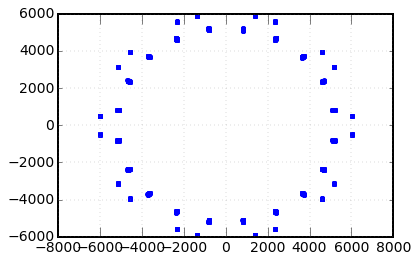

In [17]:
deadInRope(snoplus)

1989


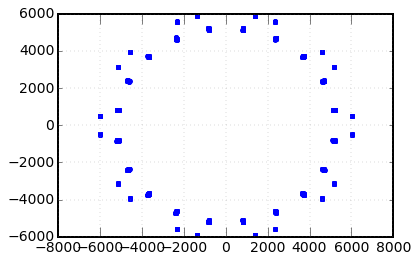

In [18]:
deadInRope(nativegeo, end_volume='snorope')